In [1]:
import tensorflow as tf
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-11 19:13:56.436400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sim_Input = 20 * torch.rand((1000, 1)) - 10
groundTruth = np.cos(sim_Input)

In [3]:
def calcParams(inputModel):
    val = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return val

In [4]:
class Optimize_NN_(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [5]:
opt_Net = Optimize_NN_()
costFunc = nn.MSELoss()
opt = optim.Adam(opt_Net.parameters(), lr=0.01)

In [6]:
def min_ratio(w):
    cnt = 0
    total = 0
    for x in w:
        if(x>0):
            cnt += 1
        total +=1
    return cnt/ total

In [7]:
def calculate_grad_norm_(model):
    grads = []
    for p in model.modules():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 
    return grad_mean

In [8]:
minRatio = []
Loss = []
train_cnt = 100
for i in range(train_cnt):
    EPOCHS = 30
    lss = 0
    opt_Net = Optimize_NN_()
    costFunc = nn.MSELoss()
    opt = optim.Adam(opt_Net.parameters(), lr=0.01)
    for epochIndex in range(EPOCHS):
        opt_Net.zero_grad()
        out1 = opt_Net(sim_Input)
        cost = costFunc(out1, groundTruth)
        with torch.no_grad():
            lss += (costFunc(out1, groundTruth))
        cost.backward()
        opt.step()
    
    Loss.append(lss/len(sim_Input))
    num_param = calcParams(opt_Net)
    
    H = torch.zeros((num_param, num_param))

    y_hat = opt_Net(sim_Input)
    y = sim_Input
    loss  = ((y_hat - y)**2).mean()
    
    J = torch.autograd.grad(loss, list(opt_Net.parameters()), create_graph=True)
    J = torch.cat([e.flatten() for e in J]) 

    
    num_param = calcParams(opt_Net)
    for i in range(num_param):
        result = torch.autograd.grad(J[i], list(opt_Net.parameters()), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result]) 
    w, v = np.linalg.eig(H)
    minRatio.append(min_ratio(w))
    

In [9]:
calculate_grad_norm_(opt_Net)

0.05094190717985233

In [10]:
num_param = calcParams(opt_Net)

In [11]:
H = torch.zeros((num_param, num_param))

y_hat = opt_Net(sim_Input)
y = sim_Input
loss  = ((y_hat - y)**2).mean()

J = torch.autograd.grad(loss, list(opt_Net.parameters()), create_graph=True)
J = torch.cat([e.flatten() for e in J])


for i in range(num_param):
    result = torch.autograd.grad(J[i], list(opt_Net.parameters()), retain_graph=True)
    H[i] = torch.cat([r.flatten() for r in result])

Text(0, 0.5, 'Loss')

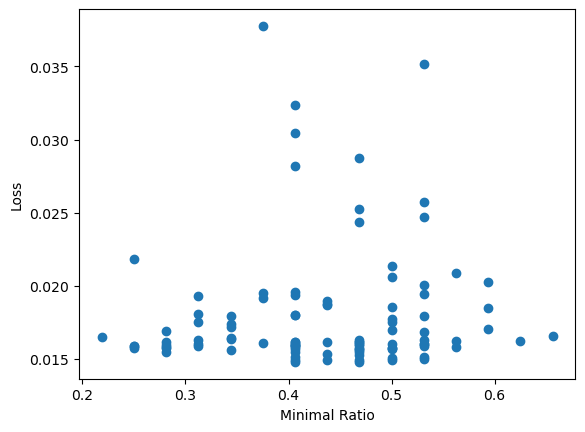

In [12]:
plt.scatter(minRatio, Loss)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')

In [13]:
len(sim_Input)

1000